In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

In [2]:
train_dataset = []
train_images_path = []

for root in os.listdir('flowers-kaggle-dataset/flower_photos_train/'):
    root_path = os.path.join('flowers-kaggle-dataset/flower_photos_train/', root)
    for file in os.listdir(root_path):
        file_path = os.path.join(root_path, file)
        train_images_path.append(file_path)
        
# Removing ".ipynb_checkpoints" directories

train_images_path.pop(2340)

'flowers-kaggle-dataset/flower_photos_train/daisy/.ipynb_checkpoints'

In [ ]:
# Index and path

counter = 0
for i in train_images_path:
    print(counter, i)
    counter += 1

In [4]:
input_images = []

for file in train_images_path[:256]:
    img = Image.open(file)
    img = img.resize((64, 64))
    img = img.convert('L')
    img = np.asarray(img)
    input_images.append(img)
    
input_images = np.asarray(input_images)

print(input_images.shape)

(256, 64, 64)


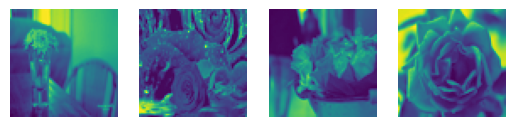

In [5]:
plt.figure()
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(input_images[i])
    plt.axis('off')
plt.show()

In [6]:
input_images = input_images.reshape(256, 4096)
input_images = (input_images.astype('float32') - 127.5) / 127.5

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

In [15]:
noise_lenght = 100

generator = Sequential()

generator.add(Dense(1024, input_dim=noise_lenght))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(4096))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(2048))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(4096))

generator.summary(0)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1024)              103424    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_9 (Dense)              (None, 4096)              4198400   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 4096)              16384     
_________________________________________________________________
dense_10 (Dense)             (None, 512)              

In [16]:
discriminator_optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator = Sequential()

discriminator.add(Dense(1024, input_dim=4096))
discriminator.add(LeakyReLU())

discriminator.add(Dense(256))
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer, metrics=['accuracy'])

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [17]:
gan_opt = Adam(lr=0.0005, beta_1=0.5)

discriminator.trainable = False

gan_input = Input(shape=(noise_lenght))

generated_image = generator(gan_input)

gan_output = discriminator(generated_image)

gan = Model(gan_input, gan_output)

gan.compile(loss='binary_crossentropy', optimizer=gan_opt, metrics=['accuracy'])

gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 4096)              15873536  
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 4457985   
Total params: 20,331,521
Trainable params: 15,858,176
Non-trainable params: 4,473,345
_________________________________________________________________


In [18]:
def plot_generated(n_ex=10, dim=(1, 10), fig_size=(12,2)):
    noise = np.random.normal(0, 1, size=(n_ex, noise_lenght))
    generated_images = generator.predict(noise)
    generated_images = generated_images * 256
    generated_images = generated_images.reshape(n_ex, 64, 64)
    plt.figure(figsize=fig_size)
    
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
plt.show()

In [12]:
def plot_loss(losses):
    d_loss = [v[0] for v in losses['D']]
    g_loss = [v[0] for v in losses['G']]
    plt.figure(figsize=(5, 4))
    plt.plot(d_loss, label='Discriminator loss')
    plt.plot(g_loss, label='Generator loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
plt.show()

In [13]:
input_images.shape

(256, 4096)

In [ ]:
num_epochs = 20
batch_size = 32
losses = {'D':[], 'G':[]}

batchCount = int(input_images.shape[0] / batch_size)

for epochs in range(num_epochs + 1):
    for _ in range(batchCount):
        noise = np.random.normal(0, 1, size=(batch_size, noise_lenght))
        
        y_true = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_true)
        fake_img = generator.predict(noise)
        
        true_img = input_images[np.random.randint(0, input_images.shape[0], size=batch_size)]
        y_fake = np.zeros(batch_size)
        discriminator.trainable = True
        
        d_loss_true = discriminator.train_on_batch(true_img, y_true)
        d_loss_fake = discriminator.train_on_batch(fake_img, y_fake)
        
        d_loss = 0.5 * np.add(d_loss_true, d_loss_fake)
        
    losses['D'].append(d_loss)
    losses['G'].append(g_loss)
    
    if epochs % 10 == 0:
        plot_generated()
        print('-' * 5, 'Epoch %d' % epochs, '-' * 5)
        print('Generator Loss:', g_loss[0])
        print('Discriminator Loss', d_loss[0])
    
    if epochs % 10 == 0:
        plot_loss(losses)
        

----- Epoch 0 -----
Generator Loss: 0.23847455
Discriminator Loss 0.8191003
----- Epoch 10 -----
Generator Loss: 1.4933937
Discriminator Loss 0.5619564
